<a href="https://colab.research.google.com/github/Abonvicine/ESTUDOS---Neural-Networks/blob/main/ESTUDO%20-%20RNN_com_multiplos_previsores.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
from keras.models import Sequential 
from keras.layers import Dense, Dropout, LSTM
from sklearn.preprocessing import MinMaxScaler 
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

In [44]:
base = pd.read_csv("/content/petr4_treinamento.csv")
base = base.dropna()
baseTreinamento = base.iloc[:, 1:7].values

normalizador = MinMaxScaler(feature_range=(0,1))
normalizadorPrevisao = MinMaxScaler(feature_range=(0,1))


normalizadorPrevisao.fit_transform(baseTreinamento[:,0:1])
baseTreinamento = normalizador.fit_transform(baseTreinamento)

In [45]:
previsores = []
precoReal = []

for i in range(90, len(baseTreinamento)):
    previsores.append(baseTreinamento[(i-90):i,0:6])
    precoReal.append(baseTreinamento[i,0])

previsores, precoReal = np.array(previsores), np.array(precoReal)
previsores.shape

(1152, 90, 6)

In [ ]:
model = Sequential()

model.add(LSTM(units=100, return_sequences = True,input_shape = (previsores.shape[1],6)))
model.add(Dropout(0.3))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.3))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.3))

model.add(LSTM(units = 50))
model.add(Dropout(0.3))

model.add(Dense(units = 1, activation= "sigmoid"))

model.compile(optimizer = "adam", loss = "mean_squared_error", metrics = ["mean_absolute_error"])

es = EarlyStopping(monitor = "loss", min_delta = 1e-10, patience = 10, verbose = 1)
rlr = ReduceLROnPlateau(monitor = "loss", factor = 0.2, patience = 5, verbose = 1)
mcp = ModelCheckpoint(filepath="pesos.h5", monitor = "loss", save_best_only = True, verbose=1)

In [ ]:
model.fit(previsores, precoReal, epochs = 100, batch_size = 32, callbacks=[es,rlr,mcp])

Epoch 1/100
36/36 [==============================] - 10s 160ms/step - loss: 0.0259 - mean_absolute_error: 0.1255

Epoch 00001: loss improved from inf to 0.01654, saving model to pesos.h5
Epoch 2/100
36/36 [==============================] - 6s 160ms/step - loss: 0.0075 - mean_absolute_error: 0.0699

Epoch 00002: loss improved from 0.01654 to 0.00643, saving model to pesos.h5
Epoch 3/100
36/36 [==============================] - 6s 160ms/step - loss: 0.0051 - mean_absolute_error: 0.0550

Epoch 00003: loss improved from 0.00643 to 0.00440, saving model to pesos.h5
Epoch 4/100
36/36 [==============================] - 6s 159ms/step - loss: 0.0043 - mean_absolute_error: 0.0505

Epoch 00004: loss improved from 0.00440 to 0.00404, saving model to pesos.h5
Epoch 5/100
36/36 [==============================] - 6s 163ms/step - loss: 0.0033 - mean_absolute_error: 0.0453

Epoch 00005: loss improved from 0.00404 to 0.00363, saving model to pesos.h5
Epoch 6/100
36/36 [==============================] - 

In [46]:
baseTeste = pd.read_csv('/content/petr4_teste.csv')
precoRealTeste = baseTeste.iloc[:,1:2].values
frames = [base,baseTeste]
baseCompleta = pd.concat(frames)
baseCompleta = baseCompleta.drop("Date",axis=1)

In [47]:
entradas = baseCompleta[len(baseCompleta)-len(baseTeste) - 90:].values
entradas = normalizador.transform(entradas)

In [48]:
X_teste = []

for i in range(90,len(entradas)):
    X_teste.append(entradas[i-90:i, 0:6])
X_teste = np.array(X_teste)
X_teste.shape

(22, 90, 6)

In [49]:
previsoes = model.predict(X_teste)
previsoes = normalizadorPrevisao.inverse_transform(previsoes)

In [52]:
print(f"desvio em reais R$ {round(previsoes.mean()-precoRealTeste.mean(),2)}")

desvio em reais R$ -0.15


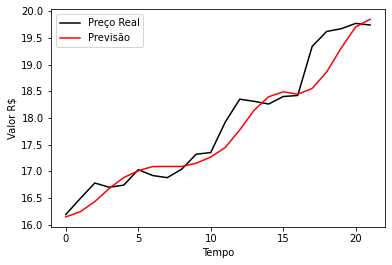

In [50]:
plt.plot(precoRealTeste, color = "black", label = "Preço Real")
plt.plot(previsoes, color = "red", label = "Previsão")
plt.xlabel("Tempo")
plt.ylabel("Valor R$")
plt.legend()
plt.show()